# 📘 Notebook: Cluster suppliers based on financial behavior.

## Step 1: Import Libraries

In [1]:
import pyodbc
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

## Step 2: Connect to SQL Server Data Warehouse

In [2]:
# SQL Server connection settings (using Windows Authentication)
server = 'localhost'  # e.g., 'localhost' or your server name
database = 'DW_Monoprix'  # Change to your target Data Warehouse
driver = '{ODBC Driver 17 for SQL Server}'

# Create connection string and connect
connection_string = f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;'
conn = pyodbc.connect(connection_string)

## Step 4: Machine learning objectives

In [3]:
# 4. Run the full aggregation query WITHOUT the HAVING clause
query4 = '''
SELECT 
    s.PK_Supplier,
    s.Name,
    s.Country,
    s.City,
    SUM(f.PaymentsSupplier_Amount) AS TotalAmountPaid,
    AVG(f.PaymentsSupplier_DiscountUsed) AS AvgDiscountUsed,
    AVG(f.PaymentsSupplier_DiscountOffered) AS AvgDiscountOffered,
    COUNT(DISTINCT f.InvoiceID) AS InvoiceCount,
    SUM(f.CashFlow_Amount) AS TotalCashFlowImpact,
    SUM(f.AJ_DebitAmount) AS TotalDebits,
    SUM(f.AJ_CreditAmount) AS TotalCredits,
    SUM(f.FinancialStatements_ActualExpenses) AS TotalActualExpenses,
    SUM(f.AF_Revenu) AS TotalRevenue,
    DATEDIFF(DAY, MIN(d.FullDate), MAX(d.FullDate)) AS BusinessRelationshipDays
FROM 
    Fact_FinancialAndAccountingManagement f
JOIN 
    DimSupplier s ON f.SupplierID = s.PK_Supplier
JOIN 
    DimDate d ON f.PsDateID = d.PK_Date
GROUP BY 
    s.PK_Supplier, s.Name, s.Country, s.City
ORDER BY 
    TotalRevenue DESC;
'''
df_suppliers_debug = pd.read_sql(query4, conn)
print("\nSample Aggregation Output:\n", df_suppliers_debug.head())
print("Number of rows:", len(df_suppliers_debug))


C:\Users\eya gadhoumi\AppData\Local\Temp\ipykernel_15400\2027137998.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_suppliers_debug = pd.read_sql(query4, conn)



Sample Aggregation Output:
    PK_Supplier             Name Country   City  TotalAmountPaid  \
0            1           Auchan  France  Paris       1908400.14   
1            2        Carrefour  France  Paris       1780004.80   
2            3          Leclerc  France  Paris       1814396.33   
3            4  Magasin Général  France  Paris       1954120.07   
4            5         Monoprix  France  Paris       1921234.13   

   AvgDiscountUsed  AvgDiscountOffered  InvoiceCount TotalCashFlowImpact  \
0         2.519294            5.838697           594                None   
1         1.626250            2.882485           569                None   
2         2.366230            4.243541           562                None   
3         1.603239            3.007298           591                None   
4         0.611366            1.423640           584                None   

  TotalDebits TotalCredits TotalActualExpenses TotalRevenue  \
0        None         None                None  

In [4]:
df_suppliers_debug = df_suppliers_debug.dropna(axis=1, how='all')


In [5]:
print("Number of rows:", len(df_suppliers_debug))

Number of rows: 160


In [6]:
print(df_suppliers_debug.isnull().sum())


PK_Supplier                 0
Name                        0
Country                     0
City                        0
TotalAmountPaid             0
AvgDiscountUsed             0
AvgDiscountOffered          0
InvoiceCount                0
BusinessRelationshipDays    0
dtype: int64


## Handle Numerical Features with StandardScaler

In [7]:
from sklearn.preprocessing import StandardScaler

# Selecting the numerical columns
numerical_cols = ['TotalAmountPaid', 'AvgDiscountUsed', 'AvgDiscountOffered', 
                  'InvoiceCount', 'BusinessRelationshipDays']

# Scaling the numerical columns
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_suppliers_debug[numerical_cols])


## Handling Categorical Features with One-Hot Encoding

In [8]:
# One-hot encoding for categorical columns
df_encoded = pd.get_dummies(df_suppliers_debug[['Country', 'City']], drop_first=True)


## Dimensionality Reduction

In [9]:
from sklearn.decomposition import PCA

# Applying PCA
pca = PCA(n_components=2)  # Reducing to 2 dimensions for visualization purposes
df_pca = pca.fit_transform(df_scaled)


In [10]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot clusters in 2D with better clarity
def plot_clusters_2D(X_reduced, labels, title):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=labels, palette='Set2', s=80, marker="o", edgecolor="black", legend="full")
    plt.title(title)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc=2)
    plt.grid(True)
    plt.show()

# KMeans Clustering

C:\Users\eya gadhoumi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\eya gadhoumi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\eya gadhoumi\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\eya gadhoumi\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\eya gadhoumi\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht,

KMeans Silhouette Score: 0.3989675229197834


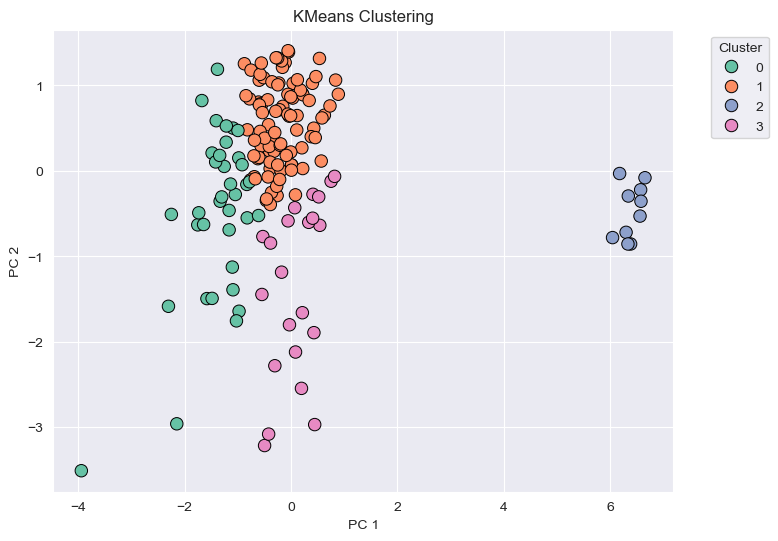

In [11]:
# --- KMeans Clustering ---
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)

# Silhouette score for KMeans
print("KMeans Silhouette Score:", silhouette_score(df_scaled, kmeans_labels))

# Plot KMeans clustering results
plot_clusters_2D(df_pca, kmeans_labels, "KMeans Clustering")

# DBSCAN Clustering

DBSCAN Silhouette Score: 0.1981867046004478


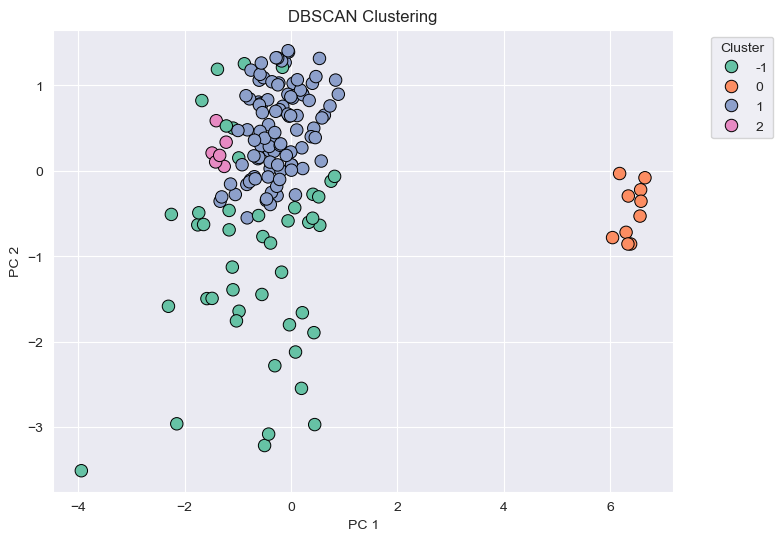

In [12]:
# --- DBSCAN Clustering ---
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples based on your data
dbscan_labels = dbscan.fit_predict(df_scaled)

# Silhouette score for DBSCAN (only if there are more than one cluster)
dbscan_score = silhouette_score(df_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else "DBSCAN cannot be evaluated due to only one cluster."
print("DBSCAN Silhouette Score:", dbscan_score)

# Plot DBSCAN clustering results
plot_clusters_2D(df_pca, dbscan_labels, "DBSCAN Clustering")

# Hierarchical Clustering

Hierarchical Clustering Silhouette Score: 0.4316009195465897


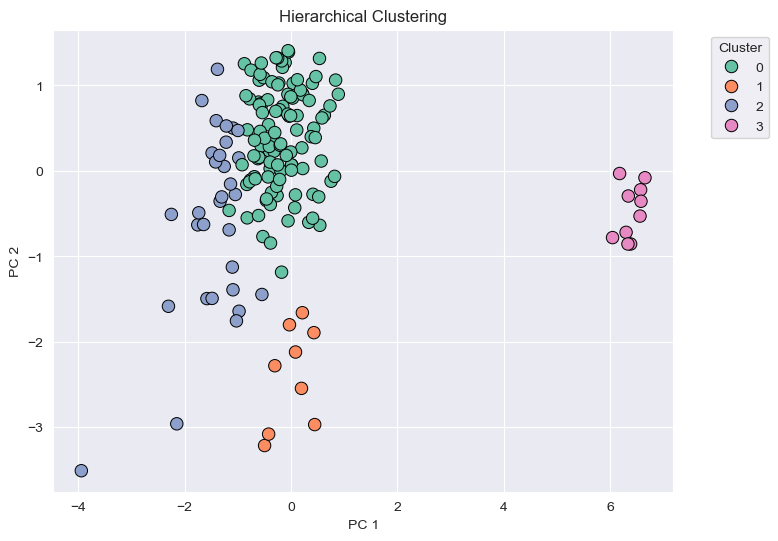

In [13]:
# --- Hierarchical Clustering ---
hierarchical = AgglomerativeClustering(n_clusters=4)  # You can adjust the number of clusters
hierarchical_labels = hierarchical.fit_predict(df_scaled)

# Silhouette score for Hierarchical Clustering
print("Hierarchical Clustering Silhouette Score:", silhouette_score(df_scaled, hierarchical_labels))

# Plot Hierarchical clustering results
plot_clusters_2D(df_pca, hierarchical_labels, "Hierarchical Clustering")

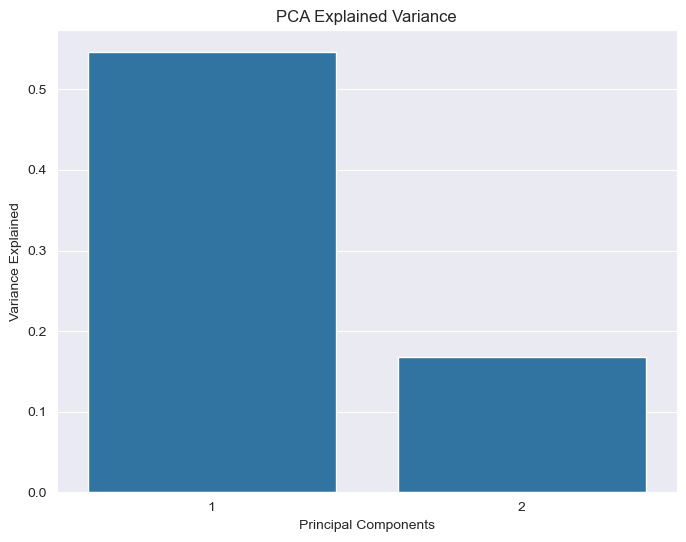

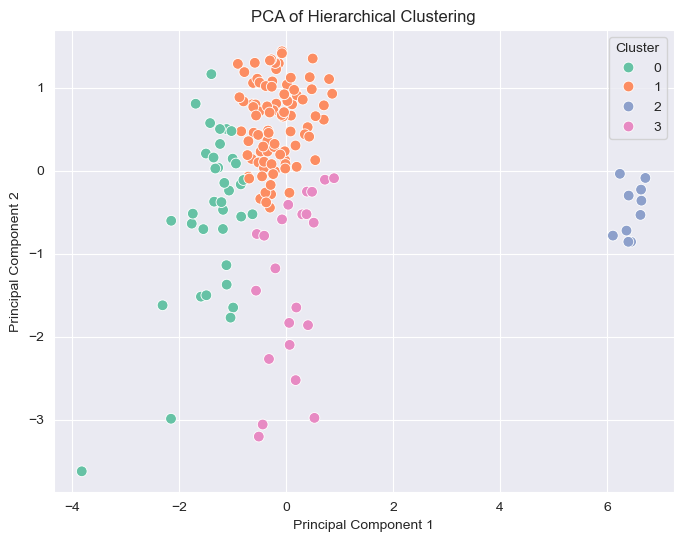

🔍 PCA Component Loadings:


,PC1,PC2
InvoiceCount,0.514865,-0.114509
TotalAmountPaid,0.514625,-0.115242
City_Paris,0.104216,-0.057733
BusinessRelationshipDays,0.094320,0.977737
City_Valence,0.001851,-0.010882
City_Tain-l’Hermitage,0.001667,0.005802
City_Dijon,0.001367,0.004926
City_Saint-Tropez,0.000857,0.007054
City_Evian,0.000838,0.002565
City_Clermont-Ferrand,0.000757,-0.001586


,PC1,PC2
BusinessRelationshipDays,0.094320,0.977737
City_Lyon,-0.007517,0.047656
City_Toulouse,-0.003616,0.023970
City_Nantes,-0.004171,0.020257
City_Marseille,-0.009719,0.020132
City_Lille,-0.005294,0.018388
City_Reims,-0.003114,0.011711
City_Montrouge,-0.000145,0.008859
City_Narbonne,-0.000577,0.008313
City_Rennes,0.000333,0.007829


In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Combine numerical and categorical data
X_combined = pd.concat([pd.DataFrame(df_scaled, columns=numerical_cols), df_encoded], axis=1)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
sns.barplot(x=[1, 2], y=pca.explained_variance_ratio_)
plt.title("PCA Explained Variance")
plt.xlabel("Principal Components")
plt.ylabel("Variance Explained")
plt.show()

# Plot the PCA components (PC1 vs PC2)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='Set2', s=60)
plt.title("PCA of Hierarchical Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# Create a DataFrame for PCA component contributions
pca_components_df = pd.DataFrame(pca.components_, columns=numerical_cols + list(df_encoded.columns), index=['PC1', 'PC2'])
print("🔍 PCA Component Loadings:")
display(pca_components_df.T.sort_values(by='PC1', ascending=False).head(10))  # Top for PC1
display(pca_components_df.T.sort_values(by='PC2', ascending=False).head(10))  # Top for PC2


 Summary Interpretation of the Clusters
 
Cluster 1 ("Reliable Payers"): High TotalAmountPaid, high InvoiceCount, long BusinessRelationshipDays. Likely to be positioned on the higher side of PC1 and PC2.

Cluster 2 ("Delayed Payers"): Low TotalAmountPaid, low InvoiceCount, newer suppliers with short BusinessRelationshipDays. Likely to be positioned on the lower end of both PC1 and PC2.

Cluster 3 ("Low Revenue, High Discount"): Low TotalAmountPaid and InvoiceCount, high AvgDiscountUsed. Likely positioned on the lower end of PC1 and possibly lower or neutral on PC2.

Cluster 4 ("High Revenue, Low Discount"): High TotalAmountPaid, high InvoiceCount, low AvgDiscountUsed. Likely positioned on the higher side of PC1 and possibly neutral or positive on PC2.

In [19]:
cluster_names = {
    0: "Reliable Payers",
    1: "Delayed Payers",
    2: "Low Revenue, High Discount",
    3: "High Revenue, Low Discount"
}

# Add Hierarchical Clustering labels to the DataFrame
df_suppliers_debug["Cluster"] = hierarchical_labels

# Map the cluster numeric labels to descriptive labels
df_suppliers_debug["Cluster_Label"] = df_suppliers_debug["Cluster"].map(cluster_names)

# Preview the updated DataFrame with cluster labels
df_suppliers_debug[['PK_Supplier', 'Name', 'Cluster', 'Cluster_Label']]


KeyError: "['PC1', 'PC2'] not in index"

# all the data

In [16]:
df_suppliers_debug.to_csv("supplier_clusters.csv", index=False)

# lezem fel lezem

In [18]:
df_suppliers_debug[['PK_Supplier', 'Name', 'Cluster', 'Cluster_Label','PC1','PC2']].to_csv("supplier_clusters2.csv", index=False)

KeyError: "['PC1', 'PC2'] not in index"